In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Load cleaned data
df = pd.read_csv('../data/cleaned_panel_data.csv')

# Load focus countries
with open('../data/focus_countries.txt', 'r') as f:
    focus_countries = f.read().strip().split(',')

print(f"Dataset shape: {df.shape}")
print(f"Focus countries: {focus_countries}")
print(f"\nAvailable indicators: {[col for col in df.columns if col not in ['country', 'country_code', 'year']]}")

Dataset shape: (623, 26)
Focus countries: ['Togo', 'Nigeria', 'South Africa', 'Kenya', 'Ivory Coast', 'Egypt']

Available indicators: ['budget_deficit_surplus', 'capital_expenditure', 'consumer_price_index_cpi', 'defence_expenditure', 'education_expenditure', 'expenditure', 'exports', 'food_inflation', 'gdp_growth_rate', 'gdp_per_capita', 'government_debt', 'health_expenditure', 'imports', 'inflation_rate', 'interest_rate', 'labour_force', 'nominal_gdp', 'population', 'real_gdp', 'revenue', 'tax_revenue', 'unemployment_rate', 'value_added_tax_vat']


## 1. Calculate Core Ratios

In [3]:
# Create a copy for feature engineering
df_features = df.copy()

# 1. Debt-to-GDP ratio (primary crisis indicator)
if 'government_debt' in df_features.columns and 'nominal_gdp' in df_features.columns:
    df_features['debt_to_gdp'] = (df_features['government_debt'] / df_features['nominal_gdp']) * 100
    print("✅ Created: debt_to_gdp")
else:
    print("⚠️ Warning: Cannot calculate debt_to_gdp - missing debt or GDP data")

# 2. Budget deficit as % of GDP
if 'budget_deficit_surplus' in df_features.columns and 'nominal_gdp' in df_features.columns:
    df_features['deficit_to_gdp'] = (df_features['budget_deficit_surplus'] / df_features['nominal_gdp']) * 100
    print("✅ Created: deficit_to_gdp")

# 3. Revenue as % of GDP (revenue mobilization capacity)
if 'revenue' in df_features.columns and 'nominal_gdp' in df_features.columns:
    df_features['revenue_to_gdp'] = (df_features['revenue'] / df_features['nominal_gdp']) * 100
    print("✅ Created: revenue_to_gdp")

# 4. Expenditure as % of GDP
if 'expenditure' in df_features.columns and 'nominal_gdp' in df_features.columns:
    df_features['expenditure_to_gdp'] = (df_features['expenditure'] / df_features['nominal_gdp']) * 100
    print("✅ Created: expenditure_to_gdp")

# 5. Trade balance as % of GDP
if 'exports' in df_features.columns and 'imports' in df_features.columns and 'nominal_gdp' in df_features.columns:
    df_features['trade_balance'] = df_features['exports'] - df_features['imports']
    df_features['trade_balance_to_gdp'] = (df_features['trade_balance'] / df_features['nominal_gdp']) * 100
    print("✅ Created: trade_balance, trade_balance_to_gdp")

# 6. Tax revenue efficiency
if 'tax_revenue' in df_features.columns and 'revenue' in df_features.columns:
    df_features['tax_revenue_share'] = (df_features['tax_revenue'] / df_features['revenue']) * 100
    print("✅ Created: tax_revenue_share")

print(f"\nNew feature count: {len([c for c in df_features.columns if c not in df.columns])}")

✅ Created: debt_to_gdp
✅ Created: deficit_to_gdp
✅ Created: revenue_to_gdp
✅ Created: expenditure_to_gdp
✅ Created: trade_balance, trade_balance_to_gdp
✅ Created: tax_revenue_share

New feature count: 7


## 2. Create Debt Crisis Labels

In [4]:
# Define debt crisis based on multiple criteria
# Criteria based on IMF and World Bank thresholds for developing economies

df_features['crisis_debt_threshold'] = 0  # Debt-to-GDP > 70%
df_features['crisis_high_deficit'] = 0    # Deficit > 5% of GDP for sustained period
df_features['crisis_composite'] = 0        # Combined crisis indicator

# 1. High debt threshold (>70% for developing countries)
if 'debt_to_gdp' in df_features.columns:
    df_features.loc[df_features['debt_to_gdp'] > 70, 'crisis_debt_threshold'] = 1
    debt_crisis_count = df_features['crisis_debt_threshold'].sum()
    print(f"High debt periods (>70% GDP): {debt_crisis_count} ({debt_crisis_count/len(df_features)*100:.1f}%)")

# 2. Severe deficit (deficit > 5% of GDP)
if 'deficit_to_gdp' in df_features.columns:
    df_features.loc[df_features['deficit_to_gdp'] < -5, 'crisis_high_deficit'] = 1
    deficit_crisis_count = df_features['crisis_high_deficit'].sum()
    print(f"High deficit periods (>5% GDP): {deficit_crisis_count} ({deficit_crisis_count/len(df_features)*100:.1f}%)")

# 3. Composite crisis indicator (either condition triggers crisis)
df_features['crisis_composite'] = ((df_features['crisis_debt_threshold'] == 1) | 
                                    (df_features['crisis_high_deficit'] == 1)).astype(int)

composite_crisis_count = df_features['crisis_composite'].sum()
print(f"\nComposite crisis periods: {composite_crisis_count} ({composite_crisis_count/len(df_features)*100:.1f}%)")

# Show crisis distribution by country
print("\nCrisis distribution by country:")
crisis_summary = df_features.groupby('country').agg({
    'crisis_composite': ['sum', 'mean'],
    'debt_to_gdp': 'mean'
}).round(2)
crisis_summary.columns = ['Crisis_Count', 'Crisis_Rate', 'Avg_Debt_GDP']
print(crisis_summary.sort_values('Crisis_Rate', ascending=False))

High debt periods (>70% GDP): 48 (7.7%)
High deficit periods (>5% GDP): 61 (9.8%)

Composite crisis periods: 82 (13.2%)

Crisis distribution by country:
              Crisis_Count  Crisis_Rate  Avg_Debt_GDP
country                                              
Egypt                   20         0.45       1781.04
Togo                    22         0.36         54.36
Nigeria                 15         0.33      21803.66
Ivory Coast             17         0.26           NaN
Senegal                  3         0.12           NaN
Rwanda                   3         0.08         45.86
Ghana                    1         0.02         42.87
South Africa             1         0.02         38.91
Algeria                  0         0.00           NaN
Angola                   0         0.00           NaN
Ethiopia                 0         0.00           NaN
Botswana                 0         0.00           NaN
Kenya                    0         0.00           NaN
Tanzania                 0         0.

## 3. Create Temporal Features (Trends & Momentum)

In [5]:
# Sort by country and year for time-series operations
df_features = df_features.sort_values(['country', 'year'])

# Function to create lagged and rolling features
def create_temporal_features(df, country_col='country', year_col='year', window=3):
    """
    Create temporal features: lags, changes, rolling statistics
    """
    df_temp = df.copy()
    
    # Key indicators for temporal features
    temporal_cols = ['debt_to_gdp', 'deficit_to_gdp', 'gdp_growth_rate', 
                     'inflation_rate', 'revenue_to_gdp', 'trade_balance_to_gdp']
    
    # Filter to available columns
    temporal_cols = [col for col in temporal_cols if col in df_temp.columns]
    
    for col in temporal_cols:
        # 1-year change
        df_temp[f'{col}_change_1y'] = df_temp.groupby(country_col)[col].diff(1)
        
        # 3-year change
        df_temp[f'{col}_change_3y'] = df_temp.groupby(country_col)[col].diff(3)
        
        # Rolling average (3-year)
        df_temp[f'{col}_rolling_avg'] = df_temp.groupby(country_col)[col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        
        # Rolling standard deviation (volatility)
        df_temp[f'{col}_volatility'] = df_temp.groupby(country_col)[col].transform(
            lambda x: x.rolling(window=window, min_periods=2).std()
        )
    
    return df_temp

print("Creating temporal features...")
df_features = create_temporal_features(df_features)

# Count new features
new_features = [c for c in df_features.columns if any(x in c for x in ['_change_', '_rolling_', '_volatility'])]
print(f"✅ Created {len(new_features)} temporal features")
print(f"Examples: {new_features[:5]}")

Creating temporal features...
✅ Created 24 temporal features
Examples: ['debt_to_gdp_change_1y', 'debt_to_gdp_change_3y', 'debt_to_gdp_rolling_avg', 'debt_to_gdp_volatility', 'deficit_to_gdp_change_1y']


## 4. Create Deficit Persistence Features

In [6]:
# Count consecutive deficit years (indicator of fiscal stress)
def count_consecutive_deficits(group):
    """
    Count consecutive years of budget deficits
    """
    if 'deficit_to_gdp' not in group.columns:
        return pd.Series(0, index=group.index)
    
    is_deficit = (group['deficit_to_gdp'] < 0).astype(int)
    
    # Calculate consecutive count
    consecutive = []
    count = 0
    for val in is_deficit:
        if val == 1:
            count += 1
        else:
            count = 0
        consecutive.append(count)
    
    return pd.Series(consecutive, index=group.index)

if 'deficit_to_gdp' in df_features.columns:
    df_features['consecutive_deficit_years'] = df_features.groupby('country').apply(
        count_consecutive_deficits
    ).reset_index(level=0, drop=True)
    
    print("✅ Created: consecutive_deficit_years")
    print(f"Max consecutive deficits: {df_features['consecutive_deficit_years'].max():.0f} years")
    print(f"Countries with 5+ consecutive deficits: {df_features[df_features['consecutive_deficit_years'] >= 5]['country'].nunique()}")

✅ Created: consecutive_deficit_years
Max consecutive deficits: 18 years
Countries with 5+ consecutive deficits: 9


## 5. Feature Summary & Selection

In [7]:
# Identify all feature columns (excluding identifiers and labels)
identifier_cols = ['country', 'country_code', 'year']
label_cols = ['crisis_debt_threshold', 'crisis_high_deficit', 'crisis_composite']
original_indicators = [c for c in df.columns if c not in identifier_cols]

# All feature columns
all_features = [c for c in df_features.columns if c not in identifier_cols + label_cols]

print(f"Total feature count: {len(all_features)}")
print(f"  - Original indicators: {len(original_indicators)}")
print(f"  - Engineered features: {len(all_features) - len(original_indicators)}")

# Check for features with too many missing values
missing_pct = df_features[all_features].isnull().sum() / len(df_features) * 100
high_missing = missing_pct[missing_pct > 70].sort_values(ascending=False)

if len(high_missing) > 0:
    print(f"\n⚠️ Features with >70% missing values ({len(high_missing)}):")
    print(high_missing.head(10))

# Select features with reasonable coverage (<70% missing)
usable_features = missing_pct[missing_pct <= 70].index.tolist()
print(f"\n✅ Usable features: {len(usable_features)}")

Total feature count: 55
  - Original indicators: 23
  - Engineered features: 32

⚠️ Features with >70% missing values (14):
education_expenditure    96.950241
labour_force             94.060995
health_expenditure       93.097913
value_added_tax_vat      90.048154
unemployment_rate        89.406100
gdp_per_capita           89.085072
defence_expenditure      88.443018
food_inflation           83.627608
debt_to_gdp_change_3y    80.256822
debt_to_gdp_change_1y    78.330658
dtype: float64

✅ Usable features: 41


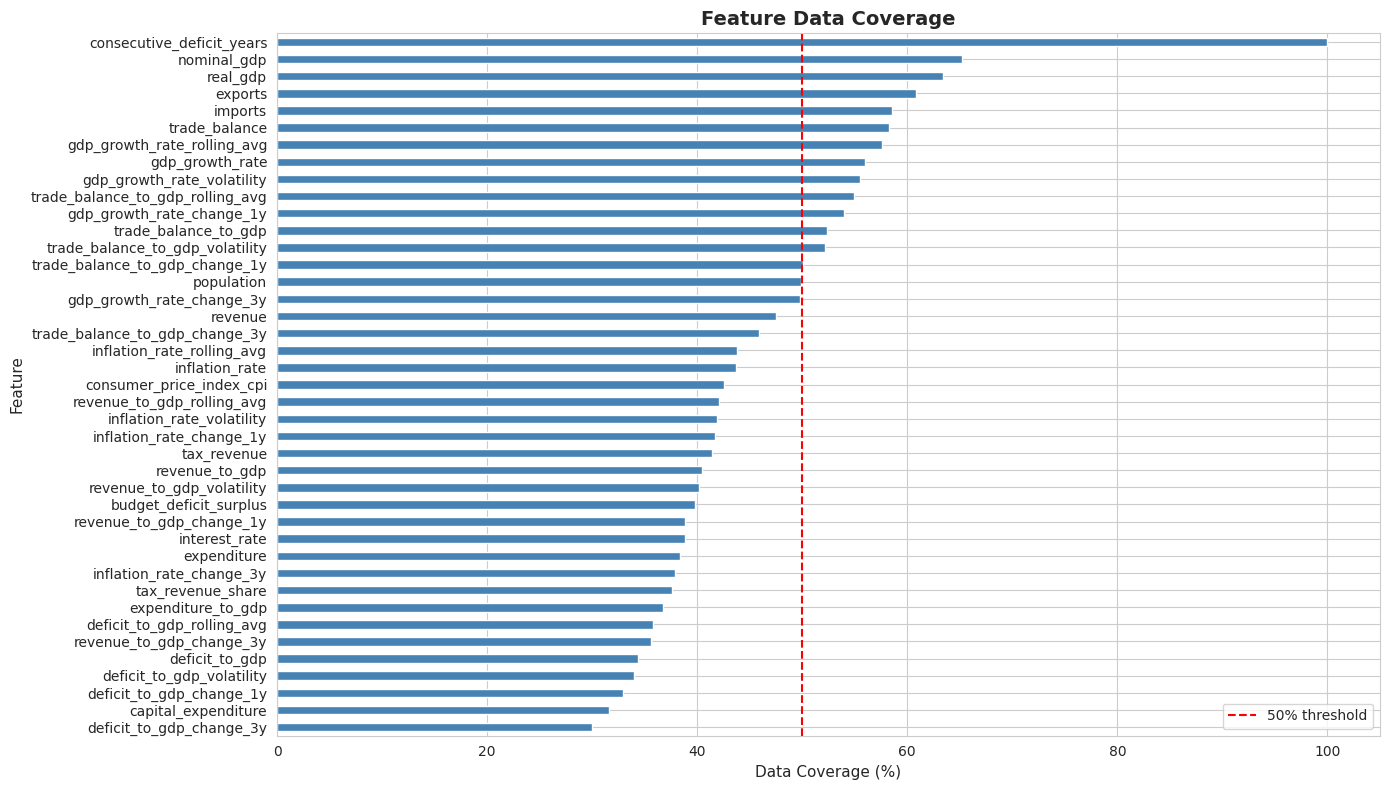


Features with >50% coverage: 14


In [8]:
# Visualize feature coverage
plt.figure(figsize=(14, 8))
coverage = (100 - missing_pct[usable_features]).sort_values(ascending=True)
coverage.plot(kind='barh', color='steelblue')
plt.xlabel('Data Coverage (%)', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.title('Feature Data Coverage', fontsize=14, fontweight='bold')
plt.axvline(x=50, color='red', linestyle='--', label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nFeatures with >50% coverage: {len(coverage[coverage > 50])}")

## 6. Handle Missing Values

In [9]:
# Create ML-ready dataset
ml_data = df_features[identifier_cols + usable_features + label_cols].copy()

print(f"ML dataset shape: {ml_data.shape}")
print(f"Missing values before imputation:")
print(ml_data[usable_features].isnull().sum().sum(), "total missing values")

# Strategy: Forward fill within each country (assumes recent values are relevant)
# Then backward fill if needed
for country in ml_data['country'].unique():
    mask = ml_data['country'] == country
    ml_data.loc[mask, usable_features] = ml_data.loc[mask, usable_features].fillna(method='ffill').fillna(method='bfill')

# For any remaining NaNs, fill with median (conservative approach)
for col in usable_features:
    if ml_data[col].isnull().any():
        median_val = ml_data[col].median()
        ml_data[col].fillna(median_val, inplace=True)

print(f"\nMissing values after imputation: {ml_data[usable_features].isnull().sum().sum()}")
print("✅ Missing value imputation complete")

ML dataset shape: (623, 47)
Missing values before imputation:
13631 total missing values

Missing values after imputation: 0
✅ Missing value imputation complete


## 7. Train-Test Split

In [10]:
# Remove rows where target variable is NaN
ml_data_clean = ml_data.dropna(subset=['crisis_composite'])

print(f"Clean dataset shape: {ml_data_clean.shape}")
print(f"Crisis rate in dataset: {ml_data_clean['crisis_composite'].mean()*100:.1f}%")

# Temporal split: train on earlier years, test on recent years
split_year = ml_data_clean['year'].quantile(0.75)  # Use 75th percentile as split

train_data = ml_data_clean[ml_data_clean['year'] < split_year]
test_data = ml_data_clean[ml_data_clean['year'] >= split_year]

print(f"\nTemporal split at year: {split_year:.0f}")
print(f"Train set: {len(train_data)} observations ({train_data['year'].min():.0f}-{train_data['year'].max():.0f})")
print(f"Test set: {len(test_data)} observations ({test_data['year'].min():.0f}-{test_data['year'].max():.0f})")

print(f"\nCrisis rate in train set: {train_data['crisis_composite'].mean()*100:.1f}%")
print(f"Crisis rate in test set: {test_data['crisis_composite'].mean()*100:.1f}%")

# Check country distribution
print(f"\nCountries in train: {train_data['country'].nunique()}")
print(f"Countries in test: {test_data['country'].nunique()}")

Clean dataset shape: (623, 47)
Crisis rate in dataset: 13.2%

Temporal split at year: 2014
Train set: 456 observations (1960-2013)
Test set: 167 observations (2014-2025)

Crisis rate in train set: 9.9%
Crisis rate in test set: 22.2%

Countries in train: 14
Countries in test: 14


## 8. Feature Scaling

In [11]:
# Separate features and target
X_train = train_data[usable_features]
y_train = train_data['crisis_composite']
X_test = test_data[usable_features]
y_test = test_data['crisis_composite']

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=usable_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=usable_features, index=X_test.index)

print("✅ Feature scaling complete")
print(f"\nScaled training features shape: {X_train_scaled.shape}")
print(f"Scaled test features shape: {X_test_scaled.shape}")

✅ Feature scaling complete

Scaled training features shape: (456, 41)
Scaled test features shape: (167, 41)


## 9. Export Feature-Ready Dataset

In [12]:
# Save complete feature dataset
ml_data_clean.to_csv('../data/ml_features_complete.csv', index=False)
print("✅ Saved: ml_features_complete.csv")

# Save train/test splits (unscaled)
train_data.to_csv('../data/ml_train.csv', index=False)
test_data.to_csv('../data/ml_test.csv', index=False)
print("✅ Saved: ml_train.csv, ml_test.csv")

# Save scaled versions
X_train_scaled.to_csv('../data/ml_X_train_scaled.csv', index=True)
X_test_scaled.to_csv('../data/ml_X_test_scaled.csv', index=True)
y_train.to_csv('../data/ml_y_train.csv', index=True, header=True)
y_test.to_csv('../data/ml_y_test.csv', index=True, header=True)
print("✅ Saved: ml_X_train_scaled.csv, ml_X_test_scaled.csv, ml_y_train.csv, ml_y_test.csv")

# Save feature list
with open('../data/feature_list.txt', 'w') as f:
    f.write('\n'.join(usable_features))
print("✅ Saved: feature_list.txt")

# Save scaler for later use
import joblib
joblib.dump(scaler, '../models/feature_scaler.pkl')
print("✅ Saved: feature_scaler.pkl")

✅ Saved: ml_features_complete.csv
✅ Saved: ml_train.csv, ml_test.csv
✅ Saved: ml_X_train_scaled.csv, ml_X_test_scaled.csv, ml_y_train.csv, ml_y_test.csv
✅ Saved: feature_list.txt
✅ Saved: feature_scaler.pkl


## 10. Feature Engineering Summary

In [13]:
print("="*70)
print("FEATURE ENGINEERING SUMMARY")
print("="*70)

print(f"\n1. DATASET:")
print(f"   Total observations: {len(ml_data_clean)}")
print(f"   Training set: {len(train_data)} ({len(train_data)/len(ml_data_clean)*100:.1f}%)")
print(f"   Test set: {len(test_data)} ({len(test_data)/len(ml_data_clean)*100:.1f}%)")

print(f"\n2. FEATURES:")
print(f"   Total features: {len(usable_features)}")
print(f"   - Core ratios: ~8 (debt-to-GDP, deficit-to-GDP, etc.)")
print(f"   - Temporal features: {len([f for f in usable_features if any(x in f for x in ['change', 'rolling', 'volatility'])])}")
print(f"   - Original indicators: {len([f for f in usable_features if f in original_indicators])}")

print(f"\n3. TARGET VARIABLE (Crisis):")
print(f"   Crisis definition: Debt-to-GDP >70% OR Deficit >5% of GDP")
print(f"   Overall crisis rate: {ml_data_clean['crisis_composite'].mean()*100:.1f}%")
print(f"   Train crisis rate: {y_train.mean()*100:.1f}%")
print(f"   Test crisis rate: {y_test.mean()*100:.1f}%")

print(f"\n4. DATA QUALITY:")
print(f"   Features with >50% coverage: {len([f for f in usable_features if (100 - missing_pct[f]) > 50])}")
print(f"   Missing values imputed: Yes (forward/backward fill + median)")
print(f"   Feature scaling: StandardScaler (mean=0, std=1)")

print(f"\n5. KEY FEATURES FOR MODELING:")
# List top features by coverage
top_features = (100 - missing_pct[usable_features]).sort_values(ascending=False).head(15)
for i, (feat, cov) in enumerate(top_features.items(), 1):
    print(f"   {i:2d}. {feat:40s} ({cov:5.1f}% coverage)")

print("\n" + "="*70)
print("✅ Feature Engineering Complete! Ready for ML Model Training")
print("="*70)

FEATURE ENGINEERING SUMMARY

1. DATASET:
   Total observations: 623
   Training set: 456 (73.2%)
   Test set: 167 (26.8%)

2. FEATURES:
   Total features: 41
   - Core ratios: ~8 (debt-to-GDP, deficit-to-GDP, etc.)
   - Temporal features: 20
   - Original indicators: 14

3. TARGET VARIABLE (Crisis):
   Crisis definition: Debt-to-GDP >70% OR Deficit >5% of GDP
   Overall crisis rate: 13.2%
   Train crisis rate: 9.9%
   Test crisis rate: 22.2%

4. DATA QUALITY:
   Features with >50% coverage: 14
   Missing values imputed: Yes (forward/backward fill + median)
   Feature scaling: StandardScaler (mean=0, std=1)

5. KEY FEATURES FOR MODELING:
    1. consecutive_deficit_years                (100.0% coverage)
    2. nominal_gdp                              ( 65.2% coverage)
    3. real_gdp                                 ( 63.4% coverage)
    4. exports                                  ( 60.8% coverage)
    5. imports                                  ( 58.6% coverage)
    6. trade_balance     

## ✅ Feature Engineering Complete!

### What Was Done:
1. **Core Ratios Created**: Debt-to-GDP, deficit-to-GDP, revenue-to-GDP, expenditure-to-GDP, trade-balance-to-GDP
2. **Crisis Labels Defined**: Debt >70% GDP OR Deficit >5% GDP
3. **Temporal Features**: 1-year & 3-year changes, rolling averages, volatility measures
4. **Persistence Features**: Consecutive deficit years tracking
5. **Missing Value Handling**: Forward/backward fill + median imputation
6. **Train-Test Split**: Temporal split (75/25) to avoid data leakage
7. **Feature Scaling**: StandardScaler for normalized inputs

### Outputs:
- `ml_features_complete.csv` - Full feature dataset
- `ml_train.csv` / `ml_test.csv` - Train/test splits
- `ml_X_train_scaled.csv` / `ml_X_test_scaled.csv` - Scaled features
- `ml_y_train.csv` / `ml_y_test.csv` - Target labels
- `feature_list.txt` - List of all features
- `feature_scaler.pkl` - Fitted scaler for deployment

### Next Step:
**ML Model Training** (`03_ml_debt_crisis.ipynb`)
- Random Forest Classifier
- XGBoost Classifier
- Logistic Regression
- Model comparison & evaluation
- Feature importance analysis
- Country risk score generation